In [1]:
%reload_ext autoreload
%autoreload 1
import torch 
from matplotlib import pyplot
import sys
import numpy as np
sys.path.append('..')
from torch import nn 
from torch.nn import functional as F
from torch import optim
from utils.loader import load
from utils.loader import PairSetMNIST
import torch.utils.data as dt
from torch.utils.data import Dataset, DataLoader
from utils.plot import learning_curve
from utils.metrics import accuracy, compute_nb_errors

In [2]:
class LeNet_aux_sequential(nn.Module):
    
    """
    Weight sharing + Auxiliary loss
    
    """
    def __init__(self):
        super(LeNet_aux_sequential, self).__init__()
        # convolutional weights for digit reocgnition shared for each image
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)
        
        # weights for binary classification 
        self.fc3 = nn.Linear(20, 60)
        self.fc4 = nn.Linear(60, 90)
        self.fc5 = nn.Linear(90, 2)
        
    def forward(self, input_):    
        
        # split the 2-channel input into two 14*14 images
        x = input_[:, 0, :, :].view(-1, 1, 14, 14)
        y = input_[:, 1, :, :].view(-1, 1, 14, 14)
        
        # forward pass for the first image 
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        
        # forward pass for the second image 
        y = F.relu(F.max_pool2d(self.conv1(y), kernel_size=2, stride=2))
        y = F.relu(F.max_pool2d(self.conv2(y), kernel_size=2, stride=2))
        y = F.relu(self.fc1(y.view(-1, 256)))
        y = self.fc2(y)
        
        # concatenate layers  
        z = torch.cat([x, y], 1)
        
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = self.fc5(z)
        
        return x, y, z

In [3]:
#train for one epoch
def train_aux (model, train_data, validation_data, mini_batch_size=100, optimizer = optim.SGD,
                criterion = nn.CrossEntropyLoss(), n_epochs=50, eta=1e-1, lambda_l2 = 0, alpha=0.5, beta=0.5):
    
    """
    Train network with auxiliary loss + weight sharing
    
    """
    train_acc = []
    train_losses = []
    valid_acc = []
    valid_losses = []
    
    model.train()
    optimizer = optimizer(model.parameters(), lr = eta)
    
    for e in range(n_epochs):
        epoch_loss = 0
        train_loader = DataLoader(train_data, batch_size=mini_batch_size, shuffle=True)
        
        for i, data in enumerate(train_loader, 0):
            
            input_, target_, classes_ = data
            class_1, class_2, out = model(input_)
            aux_loss1 = criterion(class_1, classes_[:,0])
            aux_loss2 = criterion(class_2, classes_[:,1])
            out_loss  = criterion(out, target_)
            net_loss = (alpha * (out_loss) + beta * (aux_loss1 + aux_loss2) )
            epoch_loss += net_loss
            
            if lambda_l2 != 0:
                for p in model.parameters():
                    epoch_loss += lambda_l2 * p.pow(2).sum() # add an l2 penalty term to the loss 
            
            optimizer.zero_grad()
            net_loss.backward()
            optimizer.step()
            
        tr_loss, tr_acc = compute_metrics(model, train_data)
        val_loss, val_acc = compute_metrics(model, validation_data)
        
        train_losses.append(tr_loss)
        train_acc.append(tr_acc)
        valid_acc.append(val_acc)
        valid_losses.append(val_loss)
            
        print('Train Epoch: {}  | Loss {:.6f}'.format(
                e, epoch_loss.item()))
        
    return train_losses, train_acc, valid_acc, valid_losses
        
# compute loss and accuracy
def compute_metrics(model, test_data, mini_batch_size=100, criterion = nn.CrossEntropyLoss()):
    
    """
    function to calculate prediction accuracy + loss of a cnn with auxiliary loss
    
    """
    test_loader = DataLoader(test_data, batch_size=mini_batch_size, shuffle=False)
    model.eval()
    test_loss = 0
    nb_errors = 0
    
    with torch.no_grad():
        
        for i, data in enumerate(test_loader, 0):
            input_, target_, classes_ = data
            _, _, output = model(input_) 
            batch_loss = criterion(output, target_)
            test_loss += batch_loss     
            nb_errors += compute_nb_errors(output, target_)
            
        acc = 100*(1 - (nb_errors/test_data.len) )
        test_loss = test_loss/test_data.len     # normalize loss
      
                    
        #print('\nSet | Loss: {:.4f} | Accuracy: {:.2f}%\n'.format(test_loss.item(), acc))
        
        return test_loss.item(), acc

# run a model for 10 rounds of train/test and compute results


"""

def test_trial(n_trial, n_epochs_):
    
    train_data = PairSetMNIST(train=True)
    test_data  = PairSetMNIST(test=True)

    accuracies_test = torch.empty(n_trial, dtype = float)
    accuracies_train = torch.empty(n_trial, dtype = float)
    losses_train = torch.empty(n_trial, dtype = float)
    losses_test = torch.empty(n_trial, dtype = float)

    for n in range(n_trial):

        model = LeNet_aux_sequential()
        model.train(True)
        train_aux (model, train_data, n_epochs=n_epochs_ )
        test_loss, acc_test = test_aux(model, test_data)
        train_loss, acc_train = test_aux(model, train_data)

        accuracies_test[n] = acc_test
        accuracies_train[n] = acc_train
        losses_test[n] = test_loss
        losses_train[n] = train_loss
        
        
    return accuracies_train, losses_train, accuracies_test, losses_test
    
"""



'\n\ndef test_trial(n_trial, n_epochs_):\n    \n    train_data = PairSetMNIST(train=True)\n    test_data  = PairSetMNIST(test=True)\n\n    accuracies_test = torch.empty(n_trial, dtype = float)\n    accuracies_train = torch.empty(n_trial, dtype = float)\n    losses_train = torch.empty(n_trial, dtype = float)\n    losses_test = torch.empty(n_trial, dtype = float)\n\n    for n in range(n_trial):\n\n        model = LeNet_aux_sequential()\n        model.train(True)\n        train_aux (model, train_data, n_epochs=n_epochs_ )\n        test_loss, acc_test = test_aux(model, test_data)\n        train_loss, acc_train = test_aux(model, train_data)\n\n        accuracies_test[n] = acc_test\n        accuracies_train[n] = acc_train\n        losses_test[n] = test_loss\n        losses_train[n] = train_loss\n        \n        \n    return accuracies_train, losses_train, accuracies_test, losses_test\n    \n'

In [4]:
# evaluate models 

train_data = PairSetMNIST(train=True)
valid_data = PairSetMNIST(valid=True)
test_data   = PairSetMNIST(test=True)

model = LeNet_aux_sequential()
train_losses, train_acc, valid_acc, valid_losses = train_aux(model, train_data, valid_data)

Train Epoch: 0  | Loss 20.835871
Train Epoch: 1  | Loss 19.906431
Train Epoch: 2  | Loss 17.937561
Train Epoch: 3  | Loss 16.065989
Train Epoch: 4  | Loss 12.435515
Train Epoch: 5  | Loss 11.447514
Train Epoch: 6  | Loss 10.370215
Train Epoch: 7  | Loss 7.928885
Train Epoch: 8  | Loss 6.456782
Train Epoch: 9  | Loss 5.990267
Train Epoch: 10  | Loss 4.411220
Train Epoch: 11  | Loss 5.305971
Train Epoch: 12  | Loss 3.666150
Train Epoch: 13  | Loss 3.755466
Train Epoch: 14  | Loss 3.159712
Train Epoch: 15  | Loss 2.987697
Train Epoch: 16  | Loss 2.932091
Train Epoch: 17  | Loss 2.703918
Train Epoch: 18  | Loss 2.916080
Train Epoch: 19  | Loss 2.221917
Train Epoch: 20  | Loss 2.064075
Train Epoch: 21  | Loss 2.079723
Train Epoch: 22  | Loss 1.890217
Train Epoch: 23  | Loss 1.865417
Train Epoch: 24  | Loss 1.824346
Train Epoch: 25  | Loss 1.511547
Train Epoch: 26  | Loss 1.825570
Train Epoch: 27  | Loss 1.569555
Train Epoch: 28  | Loss 1.438044
Train Epoch: 29  | Loss 1.296587
Train Epoch: 

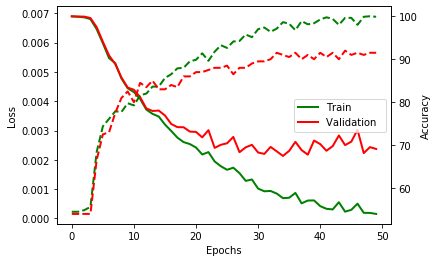

In [12]:
learning_curve(train_losses, train_acc, valid_losses, valid_acc)